# Generate a PDF describing occurence frequency in trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import metabolic as mi
import util

In [3]:
df = mi.open_traits_df()
df

,Species,Phylum,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit
0,Acanthephyra acutifrons,Crustacea,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040
1,Acanthephyra curtirostris,Crustacea,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456
2,Acanthephyra purpurea,Crustacea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330
3,Acanthephyra smithi,Crustacea,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453
4,Acipenser brevirostrum,Chordata,NaN,NaN,0.362569,0.218524,0.048415,4.513525
...,...,...,...,...,...,...,...,...
56,Styela plicata,Tunicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863
57,Systellaspis debilis,Crustacea,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196
58,Tarletonbeania crenularis,Chordata,NaN,NaN,0.213307,0.203696,0.051780,3.933876
59,Tautogolabrus adspersus,Chordata,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395


<xarray.DataArray 'Ac' (Ac: 8)>
array([0.0258, 0.0399, 0.0619, 0.0959, 0.1486, 0.2303, 0.3568, 0.5528])
Dimensions without coordinates: Ac
Attributes:
    long_name:  Hypoxic tolerance (normalized by critical MI)
    units:      1/kPa

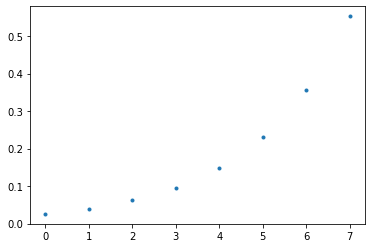

In [4]:
log10_values = np.log10(df.Ac.values)
Ac_coord_data = np.round(np.logspace(log10_values.min(), log10_values.max(), 8, base=10), 4)
Ac_coord = xr.DataArray(Ac_coord_data, dims=('Ac'), name='Ac')
Ac_coord.attrs = df.Ac.attrs
plt.plot(Ac_coord, '.');
Ac_coord

<xarray.DataArray 'Eo' (Eo: 7)>
array([-0.2, -0. ,  0.2,  0.4,  0.6,  0.8,  1. ])
Dimensions without coordinates: Eo
Attributes:
    long_name:  Temperature sensitivity of MI
    units:      eV

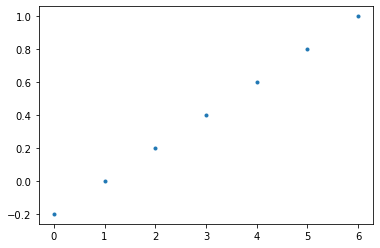

In [5]:
Eo_coord = xr.DataArray(np.round(np.linspace(-0.2, 1., 7), 4), dims=('Eo'), name=('Eo'))
Eo_coord.attrs = df.Eo.attrs
plt.plot(Eo_coord, '.');
Eo_coord

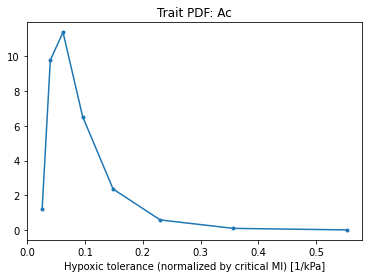

In [6]:
obj_Ac_pdf = mi.trait_pdf(df, 'Ac')
plt.plot(Ac_coord, obj_Ac_pdf.fitted(Ac_coord), '.-');
plt.title('Trait PDF: Ac');
plt.xlabel(util.attrs_label(df.Ac.attrs));

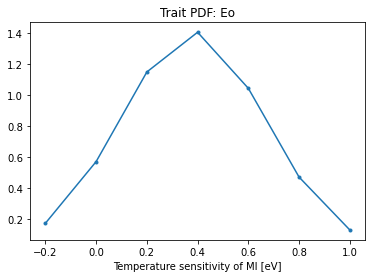

In [7]:
obj_Eo_pdf = mi.trait_pdf(df, 'Eo')
plt.plot(Eo_coord, obj_Eo_pdf.fitted(Eo_coord), '.-');
plt.title('Trait PDF: Eo');
plt.xlabel(util.attrs_label(df.Eo.attrs));

In [8]:
dso = xr.Dataset()
dso['trait_spc_wgt'] = (
    xr.DataArray(obj_Ac_pdf.fitted(Ac_coord), dims=('Ac'), coords={'Ac': Ac_coord}) *
    xr.DataArray(obj_Eo_pdf.fitted(Eo_coord), dims=('Eo'), coords={'Eo': Eo_coord})
)
dso['trait_spc_wgt'] = dso.trait_spc_wgt / dso.trait_spc_wgt.sum()                 
dso.trait_spc_wgt.attrs['long_name'] = 'Trait density'
assert dso.trait_spc_wgt.sum() == 1.

dso.trait_spc_wgt.attrs['N_traits'] = dso.trait_spc_wgt.size
dso.trait_spc_wgt.attrs['units'] = ' '.join([Eo_coord.units, Ac_coord.units])

dso

<xarray.Dataset>
Dimensions:        (Ac: 8, Eo: 7)
Coordinates:
  * Ac             (Ac) float64 0.0258 0.0399 0.0619 ... 0.2303 0.3568 0.5528
  * Eo             (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Data variables:
    trait_spc_wgt  (Ac, Eo) float64 0.001347 0.004475 ... 3.811e-05 1.041e-05

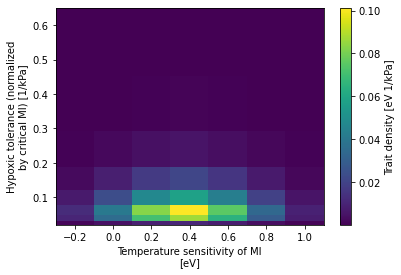

In [9]:
dso.trait_spc_wgt.plot()

In [11]:
clobber = True

this_notebook = 'trait-space-joint-pdf.ipynb'

curator = util.curator_local_assets()

if clobber:
    cache_file = 'data/cache/idealized-trait-space.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)   
    dso.to_zarr(cache_file, mode='w', consolidated=True); 
    
    curator.add_source(
        key='trait-space', 
        urlpath=cache_file,
        description=f'Idealized trait space generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )    
    
cat = curator.open_catalog()  
ds_cache = cat['trait-space'].to_dask()
xr.testing.assert_identical(dso, ds_cache)    

overwriting "trait-space" key in "sources"


/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = 